# Predicting the survivours in Titanic shipwreck. 

This notebook builds a ML algorithm to predict which passengers are survived during Titanic shipwreck. We will use python based machine learning libraries, pandas, numpy to build the model.

## Problem
Create a Machine Learning model to predict survivors in Titanic shipwerck.

## Data
Data is taken from Kaggle competition, *Titanic: Machine Learning from Disaster*

https://www.kaggle.com/c/titanic/data

## Evaluation
Evaluation metric is accuracy. 

That is the percentage of passengers we correctly predicted.

https://www.kaggle.com/c/titanic/overview/evaluation

## Features

The data has been split into two groups:

* training set (train.csv)
* test set (test.csv)

It consists of below features:
* survival
* pclass
* sex
* Age
* sibsp
* parch
* ticket
* fare
* cabin
* embarked

## Getting Workspace ready

In [1]:
import numpy as np 
import pandas as pd
import os
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
# Remaining imports will be added later whenever we require them.

## Exploratory Data Analysis (EDA)

In [2]:
# Import the data into a pandas DataFrame
df = pd.read_csv("../input/titanic/train.csv")
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [3]:
# Find the number of classes
df["Survived"].value_counts()

0    549
1    342
Name: Survived, dtype: int64

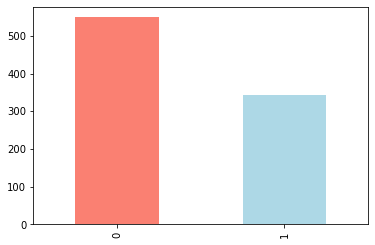

In [4]:
df["Survived"].value_counts().plot(kind="bar", color=["salmon", "lightblue"])

In [5]:
# More info about the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [6]:
# Check for any missing values
df.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

Our dataframe has missing values for Age, Cabin and Embarked columns.
In the data preprocessing stage, let's fill the missing values of age with average values, Cabin and Embarked values as 'missing'.

In [7]:
# Check all the values in cabin column
df["Cabin"].value_counts()

G6             4
B96 B98        4
C23 C25 C27    4
F2             3
E101           3
              ..
C50            1
E12            1
E77            1
E10            1
B78            1
Name: Cabin, Length: 147, dtype: int64

In [8]:
# Check all the vlaues in Embark column
df["Embarked"].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

### Survival against Sex

In [9]:
# Compare Survival column with Sex column
pd.crosstab(df.Survived, df.Sex)

Sex,female,male
Survived,,
0,81,468
1,233,109


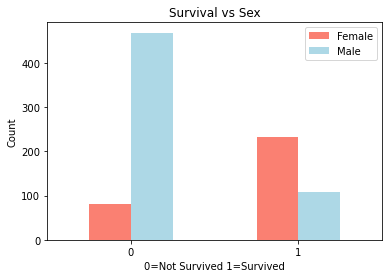

In [10]:
# create a plot for crosstab
pd.crosstab(df.Survived, df.Sex).plot(kind="bar", color=["salmon", "lightblue"])
plt.title("Survival vs Sex")
plt.xlabel("0=Not Survived 1=Survived")
plt.ylabel("Count")
plt.legend(["Female", "Male"]);
plt.xticks(rotation=0);

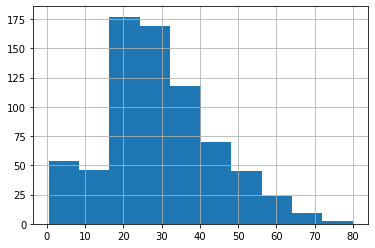

In [11]:
df.Age.hist();

In [12]:
df.Age.mean(), df.Age.median()

(29.69911764705882, 28.0)

## Data Preprocessing

### Make a copy of original dataframe

In [13]:
# make a copy
df_bkp = df.copy()

### Convert strings to numbers

One way to turn all our data into numbers is to convert them into pandas categories.
We can check different data types compatible with pandas here: https://pandas.pydata.org/pandas-docs/version/0.25.3/reference/general_utility_functions.html#data-types-related-functionality

In [14]:
pd.api.types.is_string_dtype(df["Name"])

True

In [15]:
# Find the columns which contains strings
for label, content in df.items():
    if pd.api.types.is_string_dtype(content):
        print(label)

Name
Sex
Ticket
Cabin
Embarked


In [16]:
# Turn all the string values into category values
for label, content in df.items():
    if pd.api.types.is_string_dtype(content):
        df[label] = content.astype("category").cat.as_ordered()

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   PassengerId  891 non-null    int64   
 1   Survived     891 non-null    int64   
 2   Pclass       891 non-null    int64   
 3   Name         891 non-null    category
 4   Sex          891 non-null    category
 5   Age          714 non-null    float64 
 6   SibSp        891 non-null    int64   
 7   Parch        891 non-null    int64   
 8   Ticket       891 non-null    category
 9   Fare         891 non-null    float64 
 10  Cabin        204 non-null    category
 11  Embarked     889 non-null    category
dtypes: category(5), float64(2), int64(5)
memory usage: 134.4 KB


In [18]:
df.Ticket.cat.categories

Index(['110152', '110413', '110465', '110564', '110813', '111240', '111320',
       '111361', '111369', '111426',
       ...
       'STON/O2. 3101290', 'SW/PP 751', 'W./C. 14258', 'W./C. 14263',
       'W./C. 6607', 'W./C. 6608', 'W./C. 6609', 'W.E.P. 5734', 'W/C 14208',
       'WE/P 5735'],
      dtype='object', length=681)

### Fill missing values

In [19]:
# Print all columns with are numerical
for label, content in df.items():
    if pd.api.types.is_numeric_dtype(content):
        print(label)

PassengerId
Survived
Pclass
Age
SibSp
Parch
Fare


In [20]:
# Check for which numeric columns has null values
for label, content in df.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            print(label)

Age


In [21]:
# Fill numeric rows with mean(average)
for label, content in df.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            df[label] = content.fillna(content.mean())


In [22]:
# Check if there are any null numeric values once again
for label, content in df.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            print(label)

In [23]:
df.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

### Turn categorical variables into numbers and fill missing

In [24]:
pd.Categorical(df['Cabin']).codes

array([ -1,  81,  -1,  55,  -1,  -1, 129,  -1,  -1,  -1, 145,  49,  -1,
        -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1, 111,  -1,  13,  -1,  -1,
        -1,  63,  -1,  -1,  -1,  41,  -1,  -1,  -1,  -1,  -1,  -1,  -1,
        -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,
       101,  -1,  23,  71,  -1,  -1,  -1,  -1,  -1,  21,  80,  -1,  -1,
        -1, 142,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1, 140,  -1,  -1,
        -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  63,  -1,  -1,
        -1, 122,  -1,  -1,  -1,  12,  91,  -1,  -1,  -1,  -1,  98,  -1,
        -1,  -1,  -1,  -1,  -1,  -1,  52,  -1,  -1,  -1,  -1,  -1,  -1,
        -1,  36,  -1,  -1,  -1,  -1, 116,  98,  -1,  -1,  -1, 138,  -1,
        -1,  -1,  -1,  -1,  -1,  -1, 107,  55,  -1,  45,  -1,  -1,  -1,
        -1,  -1,  -1,  -1,  -1, 141,  -1,  -1,  61,  -1,  -1,  -1,  -1,
        -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1, 123,  -1,  -1,
        -1,  18,  -1,  -1,  -1,  14,  -1,  -1,  69,  -1,  -1,  -

In [25]:
for label, content in df.items():
    if not pd.api.types.is_numeric_dtype(content):
        df[label] = pd.Categorical(content).codes + 1

In [26]:
df.isna().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
dtype: int64

### No more missing values and all the data is numeric. Ufffffff! Let's go to modelling !!

In [27]:
# Split the data into X and y
X = df.drop("Survived", axis=1)
y = df['Survived']

In [28]:
X

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,3,109,2,22.000000,1,0,524,7.2500,0,3
1,2,1,191,1,38.000000,1,0,597,71.2833,82,1
2,3,3,354,1,26.000000,0,0,670,7.9250,0,3
3,4,1,273,1,35.000000,1,0,50,53.1000,56,3
4,5,3,16,2,35.000000,0,0,473,8.0500,0,3
...,...,...,...,...,...,...,...,...,...,...,...
886,887,2,549,2,27.000000,0,0,102,13.0000,0,3
887,888,1,304,1,19.000000,0,0,15,30.0000,31,3
888,889,3,414,1,29.699118,1,2,676,23.4500,0,3
889,890,1,82,2,26.000000,0,0,9,30.0000,61,1


In [29]:
y

0      0
1      1
2      1
3      1
4      0
      ..
886    0
887    1
888    0
889    1
890    0
Name: Survived, Length: 891, dtype: int64

In [30]:
np.random.seed(42)

# Split the data into train and validation datasets

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

In [31]:
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((712, 11), (179, 11), (712,), (179,))

We are going to experiment with three models:
* Logistic Regression
* KNeighbours Classifier
* Random Forest Classifier

In [32]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

# Put models in a dictionary
models = {"Logistic Regression": LogisticRegression(),
          "KNN": KNeighborsClassifier(),
          "Random Forest": RandomForestClassifier()}

# Create a function to fit and score models
def fit_and_score(models, X_train, X_val, y_train, y_val):
    """
    Fits and evaluates given machine learning models.
    models: A dictionary of machine learning models
    X_train: training data (with no labels)
    X_val: validation data (with no labels)
    y_train: training labels
    y_vla: validation labels
    """
    # setup random seed
    np.random.seed(42)
    # create a dictionary to store model scores
    model_scores = {}
    # Loop through the models
    for name, model in models.items():
        # fit the model
        model.fit(X_train, y_train)
        # evalute the model and append the score to model_scores
        model_scores[name] = model.score(X_val, y_val)
    return model_scores

In [33]:
model_scores = fit_and_score(models, X_train, X_val, y_train, y_val)
model_scores

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


{'Logistic Regression': 0.7094972067039106,
 'KNN': 0.659217877094972,
 'Random Forest': 0.8379888268156425}

### Since Random Forest is giving a good score. We will consider it as our base model and try to further enhance it using hyperparameter tuning.

### Hyperparameter tuning using RandomizedSearchCV

In [34]:
from sklearn.model_selection import RandomizedSearchCV

# Create a hyperparameter grid for Random Forest
rf_grid = {"n_estimators": np.arange(10, 1000, 50),
           "max_depth": [None, 3, 5, 10],
           "min_samples_split": np.arange(2, 20, 2),
           "min_samples_leaf": np.arange(1, 20, 2)}

# setup random hyperparameter search for Random Forest
rs_rf = RandomizedSearchCV(RandomForestClassifier(),
                           param_distributions=rf_grid,
                           cv = 5,
                           n_iter = 50,
                           verbose = True,
                           random_state=42)

# fit hyperparameter search for RandomForest
rs_rf.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:  5.2min finished


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=50,
                   param_distributions={'max_depth': [None, 3, 5, 10],
                                        'min_samples_leaf': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                                        'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18]),
                                        'n_estimators': array([ 10,  60, 110, 160, 210, 260, 310, 360, 410, 460, 510, 560, 610,
       660, 710, 760, 810, 860, 910, 960])},
                   random_state=42, verbose=True)

In [35]:
rs_rf.best_params_

{'n_estimators': 460,
 'min_samples_split': 2,
 'min_samples_leaf': 3,
 'max_depth': None}

In [36]:
rs_rf.score(X_val, y_val)

0.8435754189944135

In [50]:
# Train model with best hyperparameters
ideal_model = RandomForestClassifier(n_estimators=460,
                                     min_samples_split=2,
                                     min_samples_leaf=3,
                                     max_depth=None,
                                     random_state=42)
# Fit the ideal model
ideal_model.fit(X_train, y_train)

RandomForestClassifier(min_samples_leaf=3, n_estimators=460, random_state=42)

In [51]:
ideal_model.score(X_val, y_val)

0.8379888268156425

## Make predictions on test data

In [39]:

df_test = pd.read_csv("../input/titanic/test.csv")
df_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [40]:
# Turn all the string values into category values
for label, content in df_test.items():
    if pd.api.types.is_string_dtype(content):
        df_test[label] = content.astype("category").cat.as_ordered()

In [41]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   PassengerId  418 non-null    int64   
 1   Pclass       418 non-null    int64   
 2   Name         418 non-null    category
 3   Sex          418 non-null    category
 4   Age          332 non-null    float64 
 5   SibSp        418 non-null    int64   
 6   Parch        418 non-null    int64   
 7   Ticket       418 non-null    category
 8   Fare         417 non-null    float64 
 9   Cabin        91 non-null     category
 10  Embarked     418 non-null    category
dtypes: category(5), float64(2), int64(4)
memory usage: 62.0 KB


In [42]:
# Fill numeric rows with mean(average)
for label, content in df_test.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            df_test[label] = content.fillna(content.mean())

In [43]:
# Turn categorical variables into numbers and fill missing
for label, content in df_test.items():
    if not pd.api.types.is_numeric_dtype(content):
        df_test[label] = pd.Categorical(content).codes + 1

In [44]:
X_test = df_test

In [45]:
test_preds = ideal_model.predict(X_test)

In [46]:
test_preds

array([0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0,
       1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1,
       0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0,
       0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [59]:
len(test_preds), len(X_test)

(418, 418)

We have made some predictions, now we have to format the output as requested by Kaggle.

In [60]:
df_preds = pd.DataFrame()
df_preds['PassengerId'] = df_test['PassengerId']
df_preds['Survived'] = test_preds
df_preds

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [63]:
# Export the predicted data
df_preds.to_csv("test_predictions.csv", index=False)